#  Shakespear Poem generation with Predicting the next word

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Attention, Input 

2.10.0


For this project we will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [14]:
!pip install gdown==5.1.0

In [15]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

C:\Users\ASUS\anaconda3\Lib\site-packages\gdown\__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: C:\Users\ASUS\OneDrive\Bureau\projects\ML Note book env\Projects\Shakespear poem generator\sonnets.txt

  0%|          | 0.00/93.6k [00:00<?, ?B/s]
100%|##########| 93.6k/93.6k [00:00<00:00, 777kB/s]
100%|##########| 93.6k/93.6k [00:00<00:00, 777kB/s]


In [16]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = [line  for line in data.split("\n")]

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

FROM fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou, contracted to thine own bright eyes,


## Tokenizing the text

Now we fit the Tokenizer to the corpus and save the total number of words.


In [18]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1
total_words

4381

In [19]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
# Save tokenizer for further use 
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [20]:
# load tokenizer 
def load_tokenizer(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        tokenizer_data = json.load(f)
    tokenizer = tokenizer_from_json(tokenizer_data)
    return tokenizer

# Test Tokenizer laod 
tokenizer = load_tokenizer("tokenizer.json")
len(tokenizer.word_index) + 1 

4381

When converting the text into sequences we can use the texts_to_sequences method .

In the next  function we will need to process this corpus one line at a time. Given this, it is important to keep in mind that the way we are feeding the data unto this method affects the result. Check the following example to make this clearer.

The first example of the corpus is a string and looks like this:


In [22]:
corpus[0]

'FROM fairest creatures we desire increase,'

If we pass this text directly into the `texts_to_sequences` method we will get an unexpected result:

In [24]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [208],
 [],
 [],
 [],
 [13],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [13],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [13],
 [],
 [],
 []]

This happened because `texts_to_sequences` expects a list and we are providing a string. However a string is still and `iterable` in Python so we will get the word index of every character in the string.

Instead we need to place the example whithin a list before passing it to the method:

In [26]:

tokenizer.texts_to_sequences([corpus[0]])
tokenizer.texts_to_sequences([corpus[0]])[0]

[33, 366, 860, 142, 235, 574]

## Generating n_grams

Now we complete the `n_gram_seqs` function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [28]:
def n_gram_seqs(corpus, tokenizer):
    input_sequences = []

    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences

In [30]:
# Test the function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[33, 366],
 [33, 366, 860],
 [33, 366, 860, 142],
 [33, 366, 860, 142, 235],
 [33, 366, 860, 142, 235, 574]]

In [31]:
# Test the function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 861],
 [8, 861, 113],
 [8, 861, 113, 575],
 [8, 861, 113, 575, 108],
 [8, 861, 113, 575, 108, 143],
 [8, 861, 113, 575, 108, 143, 576],
 [15, 19],
 [15, 19, 2],
 [15, 19, 2, 862],
 [15, 19, 2, 862, 54],
 [15, 19, 2, 862, 54, 29],
 [15, 19, 2, 862, 54, 29, 67],
 [15, 19, 2, 862, 54, 29, 67, 863],
 [23, 261],
 [23, 261, 1464],
 [23, 261, 1464, 108],
 [23, 261, 1464, 108, 236],
 [23, 261, 1464, 108, 236, 23],
 [23, 261, 1464, 108, 236, 23, 1465]]

Apply the n_gram_seqs transformation to the whole corpus and save the maximum sequence length to use it later:


In [33]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15355
maximum length of sequences is: 11


## Add padding to the sequences

Now we code the `pad_seqs` function which will pad any given sequences to the desired maximum length. 

In [35]:
def pad_seqs(input_sequences, maxlen):
    padded_sequences = np.array(pad_sequences(input_sequences, maxlen=maxlen, padding='pre'))

    return padded_sequences

In [36]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  33, 366],
       [  0,   0,   0,  33, 366, 860],
       [  0,   0,  33, 366, 860, 142],
       [  0,  33, 366, 860, 142, 235],
       [ 33, 366, 860, 142, 235, 574]])

In [37]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    8,  861],
       [   0,    0,    0,    0,    0,    8,  861,  113],
       [   0,    0,    0,    0,    8,  861,  113,  575],
       [   0,    0,    0,    8,  861,  113,  575,  108],
       [   0,    0,    8,  861,  113,  575,  108,  143],
       [   0,    8,  861,  113,  575,  108,  143,  576],
       [   0,    0,    0,    0,    0,    0,   15,   19],
       [   0,    0,    0,    0,    0,   15,   19,    2],
       [   0,    0,    0,    0,   15,   19,    2,  862],
       [   0,    0,    0,   15,   19,    2,  862,   54],
       [   0,    0,   15,   19,    2,  862,   54,   29],
       [   0,   15,   19,    2,  862,   54,   29,   67],
       [  15,   19,    2,  862,   54,   29,   67,  863],
       [   0,    0,    0,    0,    0,    0,   23,  261],
       [   0,    0,    0,    0,    0,   23,  261, 1464],
       [   0,    0,    0,    0,   23,  261, 1464,  108],
       [   0,    0,    0,   23,  261, 1464,  108,  236],
       [   0,    0,   23,  261,

In [38]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15355, 11)


## Split the data into features and labels

Before feeding the data into the neural network we should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

Notice that the function also receives the total of words in the corpus, this parameter will be very important when one hot enconding the labels since every word in the corpus will be a label at least once.


In [40]:
def features_and_labels(input_sequences, total_words):  
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels =  to_categorical(labels, num_classes=total_words)
    

    return features, one_hot_labels

In [41]:
# Test the function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features, first_labels

labels have shape: (5, 4381)

features look like this:



(array([[  0,   0,   0,   0,  33],
        [  0,   0,   0,  33, 366],
        [  0,   0,  33, 366, 860],
        [  0,  33, 366, 860, 142],
        [ 33, 366, 860, 142, 235]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [42]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15355, 10)
labels have shape: (15355, 4381)


## Create the model

Now we should define a model architecture capable of achieving an accuracy of at least 80%.

model architecture

- An appropriate `output_dim` for the first layer (Embedding) is 100.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding) .

In [44]:
def create_model(total_words, max_sequence_len):
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
    model.add(LSTM(80))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model






In [45]:
# Get the untrained model
model = create_model(total_words , max_sequence_len)
model.summary()
# Train the model
history = model.fit(features, labels, epochs=60, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           438100    
                                                                 
 lstm (LSTM)                 (None, 80)                57920     
                                                                 
 dense (Dense)               (None, 4381)              354861    
                                                                 
Total params: 850,881
Trainable params: 850,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
480/480 [==============================] - 14s 8ms/step - loss: 7.2893 - accuracy: 0.0227
Epoch 2/60
480/480 [==============================] - 4s 8ms/step - loss: 6.8060 - accuracy: 0.0289
Epoch 3/60
480/480 [==============================] - 4s 8ms/step - loss: 6.6655 - accuracy: 0.0328
Epoch 4/60
48

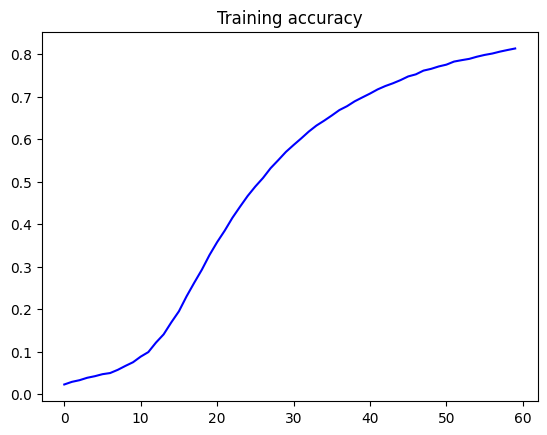

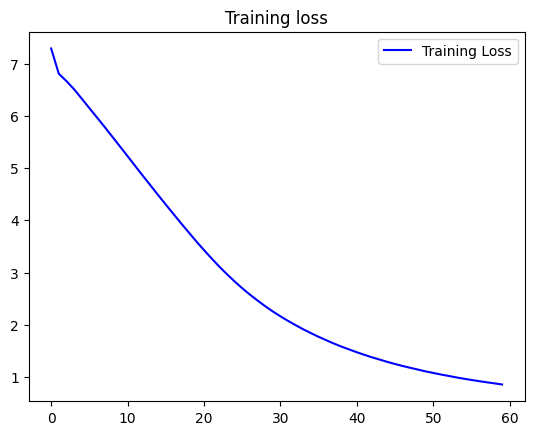

In [47]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [48]:
model.save("model/shakespear_generator.h5")

In [25]:
import numpy as np
import json
import re
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# load tokenizer 
def load_tokenizer(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        tokenizer_data = json.load(f)
    tokenizer = tokenizer_from_json(tokenizer_data)
    return tokenizer

def sample(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

def generate_poem(seed_text, model, max_sequence_len=11 ,next_words=100, temperature=0.5):
    tokenizer = load_tokenizer("tokenizer.json")
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)[0]
        predicted_word_index = sample(predicted, temperature=temperature)
        output_word = tokenizer.index_word.get(predicted_word_index)
        
        seed_text += " " + output_word
    return seed_text.strip()


def refine_shape(text):
    
    lines = re.split(r'([;:,.\?!])', text)
    buffer = []
    
    for i in range(0, len(lines), 2):  
        segment = lines[i].strip()
        punctuation = lines[i + 1] if i + 1 < len(lines) else ''
        
       
        if segment and len(segment) < 5 and buffer:
            buffer[-1] += ' ' + segment + punctuation
        else:
            buffer.append(segment + punctuation)
    
    
    return '\n'.join(buffer)
    



In [27]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model/shakespear_generator.h5")
# Example one :
print(refine_shape(generate_poem("Rough winds do shake the darling buds of May", model=loaded_model)))


Rough winds do shake the darling buds of May weeds:
woe extreme,
themselves.
woman place,
forfeit quest heart,
that is can winter grace so. so.
tender'd me.
still,
despite fame thee woe;
eye's woes place,
back whilst long.
pine afloat, now,
light'st by cover,
farther tells of subject subject 'twixt subject fortune 'twixt lips, o,
error infection way made no defect,
virtue tender me!
flowers o'ersnow'd charge?
subject subject 'twixt blessed-fair guilty whence man summer home faculty added rising rising watch lame lie check me nor thou art old,
is this,
with me. new;
have alter'd green.
again.
green.
blamed, hand,
hearts duty,
addition quest heart,
quick true,
' despite


In [29]:

print(refine_shape(generate_poem("Shall I compare thee to a summer's day", model=loaded_model)))

Shall I compare thee to a summer's day lived mourning wonder fears,
rights 'twixt charge?
'twixt lips,
win deep deep thou hence adulterate a part:
speak of me:
blesses here shadow muse;
mourning wonder wonder wonder bitterness function 'twixt offences testy strength's thievish first;
master-mistress 'twixt lack heart,
repose bad of more world had true, true,
not thee.
not still,
the kingdom die. thee. time,
tells necessary world,
break world lies, die:
staineth. old,
here holds title drawn of manners waste fame in my life is in prove still, come,
find back spur, aid,
green.
room urge repair,
read hence.
find back men, this;
pursuit 'twixt a keen
